In [1]:
from pdastro import pdastroclass, pdastrostatsclass, AandB, AnotB, AorB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as matlib

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.family'] = 'serif'
plt.rcParams["font.serif"] = 'times'

def dataPlot(x, y, dx=None, dy=None, sp=None, label=None, fmt='bo', ecolor='k', elinewidth=None, barsabove = False, capsize=1, logx=False, logy=False):
    if sp == None:
        sp = matlib.subplot(111)
    if dx is None and dy is None:
        if logy:
            if logx:
                plot, = sp.loglog(x, y, fmt)
            else:
                plot, = sp.semilogy(x, y, fmt)
        elif logx:
            plot, = sp.semilogx(x, y, fmt)
        else:
            if barsabove:
                plot, dplot,dummy = sp.errorbar(x, y, label=label, fmt=fmt, capsize=capsize, barsabove=barsabove)
            else:
                plot, = sp.plot(x, y, fmt)
        return sp, plot, None
    else:
        if logy:
            sp.set_yscale("log", nonposx='clip')
        if logx:
            sp.set_xscale("log", nonposx='clip')
        plot, dplot,dummy = sp.errorbar(x, y, xerr=dx, yerr=dy, label=label, fmt=fmt, ecolor=ecolor, elinewidth=elinewidth, capsize=capsize, barsabove=barsabove)
        return sp, plot, dplot

### General settings

In [2]:
name = '2019vxm' # enter SN name
lw_mode = False # should be set to True if your SN light curve file names do not contain the string '_i000'
show_errorbars = True # show uncertainty error bars
controls = True # plot control light curves
controls_num = 8 # are there control light curves? if not, put None; if yes, enter number of control light curves
maskcol = 'Mask' # is there a mask column? if not, put None; if yes, enter mask column name
filts = ['c','o'] # loop through filter(s)
filt_colors = {'c':'cyan','o':'orange'} # set plot colors for each filt
MJDstart = None # enter MJD to start plotting at
MJDend = None # enter MJD to end plotting at
MJDbinsize = 1 # optional setting to enter MJD bin size for averaged light curves

### Plot original light curve(s)

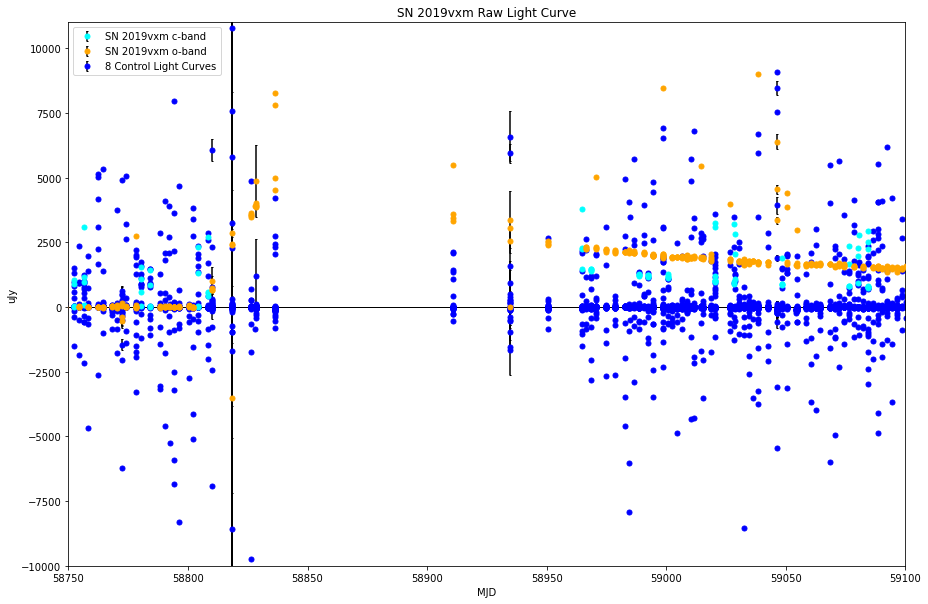

In [9]:
# PLOT-SPECIFIC SETTINGS:

# specify the plot's x and y limits (can set to None):
limits = {'xlim_lower':58750,'xlim_upper':59100,'ylim_lower':-10000,'ylim_upper':11000}

savefig = False # save figure after plotting




lc_dict = {}
if controls:
    if not(controls_num is None):
        end_num = controls_num
    else:
        print(controls_num)
        print('ERROR: no control light curve number entered in settings')
        sys.exit(1)
else:
    end_num = 0
if len(filts) < 1:
    print(filts)
    print('ERROR: must have at least one filter entered in settings')
if lw_mode and controls:
    print('ERROR: lw_mode cannot be True if control light curves used')
        
plt.figure()
for index in range(0,end_num+1):
    lc_dict[index] = pdastroclass(hexcols=[maskcol])
    for filt in filts:
        if lw_mode:
            lc_dict[index].load_spacesep(name+'.'+filt+'.txt',hexcols=['Mask'],delim_whitespace=True)
        else:
            lc_dict[index].load_spacesep(name+('_i%03d.'%index)+filt+'.lc.txt',hexcols=['Mask'],delim_whitespace=True)
        if not(MJDstart is None) or not(MJDend is None):
            indices = lc_dict[index].ix_inrange(colnames=['MJD'],lowlim=MJDstart,uplim=MJDend)
        else:
            indices = lc_dict[index].getindices()
        dy = None
        if show_errorbars: 
            dy = lc_dict[index].t.loc[indices,'duJy']
        if index == 0:
            sp, plotSN, dplotSN = dataPlot(lc_dict[index].t.loc[indices,'MJD'],lc_dict[index].t.loc[indices,'uJy'],dy=dy)
            matlib.setp(plotSN,ms=5,color=filt_colors[filt],marker='o',zorder=10)
        else:
            sp, plot, dplot = dataPlot(lc_dict[index].t.loc[indices,'MJD'],lc_dict[index].t.loc[indices,'uJy'],dy=dy)
            matlib.setp(plot,ms=5,color='b',marker='o')
plt.title('SN '+name+' Raw Light Curve')
plt.xlabel('MJD')
plt.ylabel('uJy')
plt.xlim(limits['xlim_lower'],limits['xlim_upper'])
plt.ylim(limits['ylim_lower'],limits['ylim_upper'])
legendlist = []
for filt in filts:
    legendlist.append('SN '+name+' '+filt+'-band')
if controls:
    legendlist.append('%d Control Light Curves'%end_num)
plt.legend(legendlist)
plt.axhline(linewidth=1,color='k')

if savefig:
    if len(filts)==1:
        plt.savefig(name+'.'+filts[0]+'.raw.png')
    plt.savefig(name+'.raw.png',dpi=200)

### Plot flagged and/or unflagged measurements in original light curve(s)

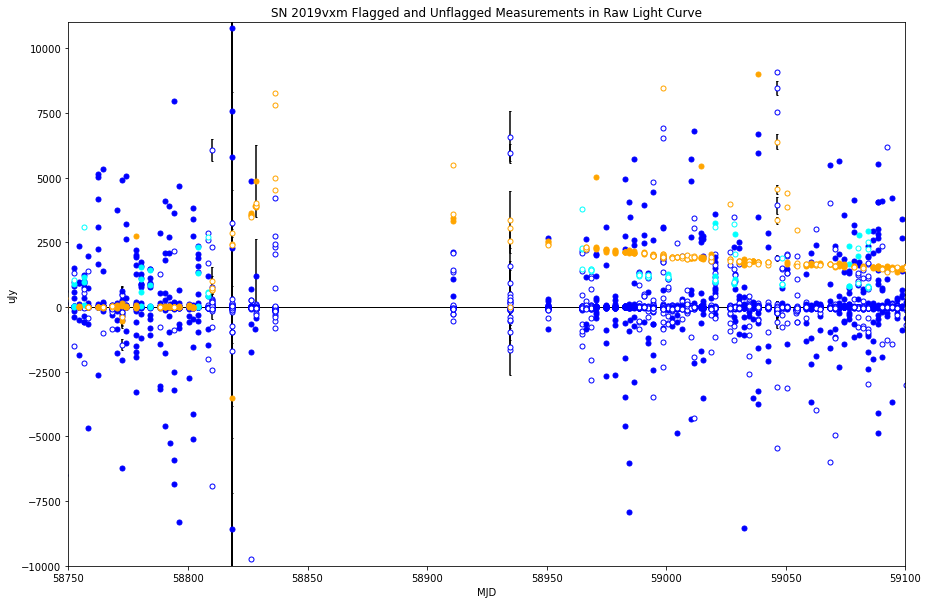

In [15]:
# PLOT-SPECIFIC SETTINGS:

# specify the plot's x and y limits (can set to None)
limits = {'xlim_lower':58750,'xlim_upper':59100,'ylim_lower':-10000,'ylim_upper':11000}

plot_flagged = True # plot flagged measurements

flag_dict = {'flag_c0_X2norm':0x1,'flag_c0_uncertainty':0x2,'flag_c0_bad':0x100000,'flag_c1_X2norm':0x10,'flag_c1_absnormmean':0x20,'flag_c2_bad':0x400000,'flag_day_bad':0x800000}
# list flags from flag_dict above to mask bad measurements (flag_c2_bad and flag_day_bad only work if you used controls)
flags_list = ['flag_c2_bad']

savefig = False # save figure after plotting




lc_dict = {}
if controls:
    if not(controls_num is None):
        end_num = controls_num
    else:
        print(controls_num)
        print('ERROR: no control light curve number entered in settings')
        sys.exit(1)
else:
    end_num = 0
if len(filts) < 1:
    print(filts)
    print('ERROR: must have at least one filter entered in settings')
if lw_mode and controls:
    print('ERROR: lw_mode cannot be True if control light curves used')

flags = 0x0
for flag in flags_list:
    flags = flags | flag_dict[flag]
plt.figure()
for index in range(0,end_num+1):
    lc_dict[index] = pdastroclass(hexcols=[maskcol])
    for filt in filts:
        if lw_mode:
            lc_dict[index].load_spacesep(name+'.'+filt+'.txt',hexcols=['Mask'],delim_whitespace=True)
        else:
            lc_dict[index].load_spacesep(name+('_i%03d.'%index)+filt+'.lc.txt',hexcols=['Mask'],delim_whitespace=True)
        if not(MJDstart is None) or not(MJDend is None):
            indices = lc_dict[index].ix_inrange(colnames=['MJD'],lowlim=MJDstart,uplim=MJDend)
        else:
            indices = lc_dict[index].getindices()
        indices_good = list(lc_dict[index].ix_unmasked('Mask',maskval=flags,indices=indices))
        indices_bad = list(lc_dict[index].ix_masked('Mask',maskval=flags,indices=indices))
        dygood = None
        dybad = None
        if show_errorbars: 
            dygood = lc_dict[index].t.loc[indices_good,'duJy']
            dybad = lc_dict[index].t.loc[indices_bad,'duJy']
        if index == 0:
            sp, plotSNg, dplotSNg = dataPlot(lc_dict[index].t.loc[indices_good,'MJD'],lc_dict[index].t.loc[indices_good,'uJy'],dy=dygood)
            matlib.setp(plotSNg,ms=5,color=filt_colors[filt],marker='o',zorder=10)
            if plot_flagged:
                sp, plotSNb, dplotSNb = dataPlot(lc_dict[index].t.loc[indices_bad,'MJD'],lc_dict[index].t.loc[indices_bad,'uJy'],dy=dybad)
                matlib.setp(plotSNb,ms=5,color=filt_colors[filt],marker='o',zorder=10,mfc='white')
        else:
            sp, plotg, dplotg = dataPlot(lc_dict[index].t.loc[indices_good,'MJD'],lc_dict[index].t.loc[indices_good,'uJy'],dy=dygood)
            matlib.setp(plotg,ms=5,color='b',marker='o')
            if plot_flagged:
                sp, plotb, dplotb = dataPlot(lc_dict[index].t.loc[indices_bad,'MJD'],lc_dict[index].t.loc[indices_bad,'uJy'],dy=dybad)
                matlib.setp(plotb,ms=5,color='b',marker='o',mfc='white')
if plot_flagged:
    plt.title('SN '+name+' Flagged and Unflagged Measurements in Raw Light Curve')
else:
    plt.title('SN '+name+' Clean Light Curve')
plt.xlabel('MJD')
plt.ylabel('uJy')
plt.xlim(limits['xlim_lower'],limits['xlim_upper'])
plt.ylim(limits['ylim_lower'],limits['ylim_upper'])
"""
if plot_flagged:
    plt.legend((plotSNg,plotSNb,plotg,plotb),('SN '+name+' unflagged','SN '+name+' flagged','%d Control Light Curves unflagged'%end_num,'%d Control Light Curves flagged'%end_num))
else:
    plt.legend((plotSNg,plotg),('SN '+name+' unflagged','%d Control Light Curves unflagged'%end_num))
"""
plt.axhline(linewidth=1,color='k')
if savefig:
    if len(filts)==1:
        plt.savefig(name+'.'+filts[0]+'.raw.clean.png')
    plt.savefig(name+'.raw.clean.png',dpi=200)

### Plot averaged light curve(s)

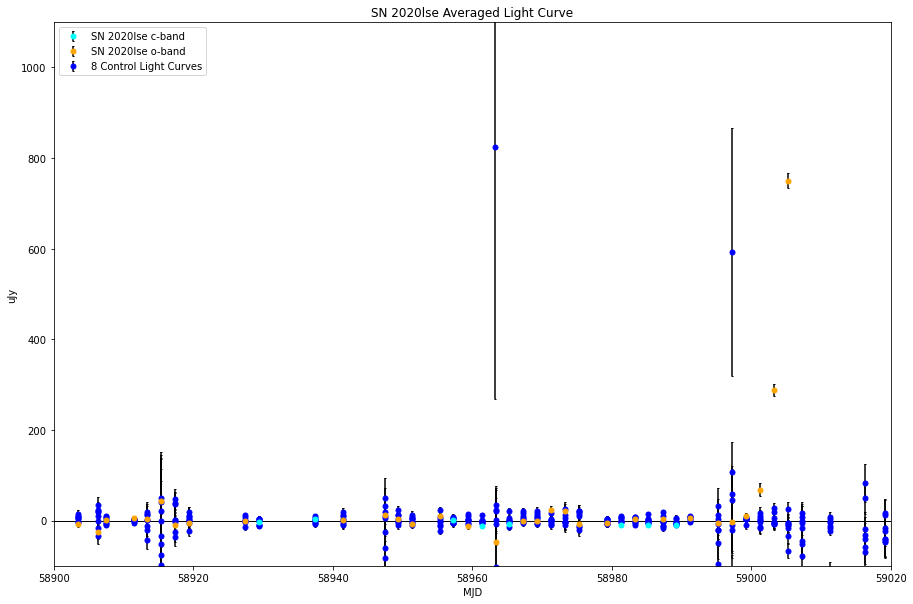

In [22]:
# PLOT-SPECIFIC SETTINGS:

# specify the plot's x and y limits (can set to None)
limits = {'xlim_lower':58900,'xlim_upper':59020,'ylim_lower':-100,'ylim_upper':1100}

savefig = False # save figure after plotting




lc_dict = {}
if controls:
    if not(controls_num is None):
        end_num = controls_num
    else:
        print(controls_num)
        print('ERROR: no control light curve number entered in settings')
        sys.exit(1)
else:
    end_num = 0
if len(filts) < 1:
    print(filts)
    print('ERROR: must have at least one filter entered in settings')
if lw_mode and controls:
    print('ERROR: lw_mode cannot be True if control light curves used')

plt.figure()
for index in range(0,end_num+1):
    lc_dict[index] = pdastroclass(hexcols=[maskcol])
    for filt in filts:
        if lw_mode:
            lc_dict[index].load_spacesep(name+'.'+filt+'.%0.2fdays.txt'%MJDbinsize,hexcols=['Mask'],delim_whitespace=True)
        else:
            lc_dict[index].load_spacesep(name+('_i%03d.'%index)+filt+'.%0.2fdays.lc.txt'%MJDbinsize,hexcols=['Mask'],delim_whitespace=True)
        if not(MJDstart is None) or not(MJDend is None):
            indices = lc_dict[index].ix_inrange(colnames=['MJD'],lowlim=MJDstart,uplim=MJDend)
        else:
            indices = lc_dict[index].getindices()
        dy = None
        if show_errorbars: 
            dy = lc_dict[index].t.loc[indices,'duJy']
        if index == 0:
            sp, plotSN, dplotSN = dataPlot(lc_dict[index].t.loc[indices,'MJD'],lc_dict[index].t.loc[indices,'uJy'],dy=dy)
            matlib.setp(plotSN,ms=5,color=filt_colors[filt],marker='o',zorder=10)
        else:
            sp, plot, dplot = dataPlot(lc_dict[index].t.loc[indices,'MJD'],lc_dict[index].t.loc[indices,'uJy'],dy=dy)
            matlib.setp(plot,ms=5,color='b',marker='o')
plt.title('SN '+name+' Averaged Light Curve')
plt.xlabel('MJD')
plt.ylabel('uJy')
plt.xlim(limits['xlim_lower'],limits['xlim_upper'])
plt.ylim(limits['ylim_lower'],limits['ylim_upper'])
legendlist = []
for filt in filts:
    legendlist.append('SN '+name+' '+filt+'-band')
if controls:
    legendlist.append('%d Control Light Curves'%end_num)
plt.legend(legendlist)
plt.axhline(linewidth=1,color='k')

if savefig:
    if len(filts)==1:
        plt.savefig(name+'.'+filts[0]+'.raw.png')
    plt.savefig(name+'.raw.png',dpi=200)

### Plot flagged and/or unflagged measurements in averaged light curve(s)

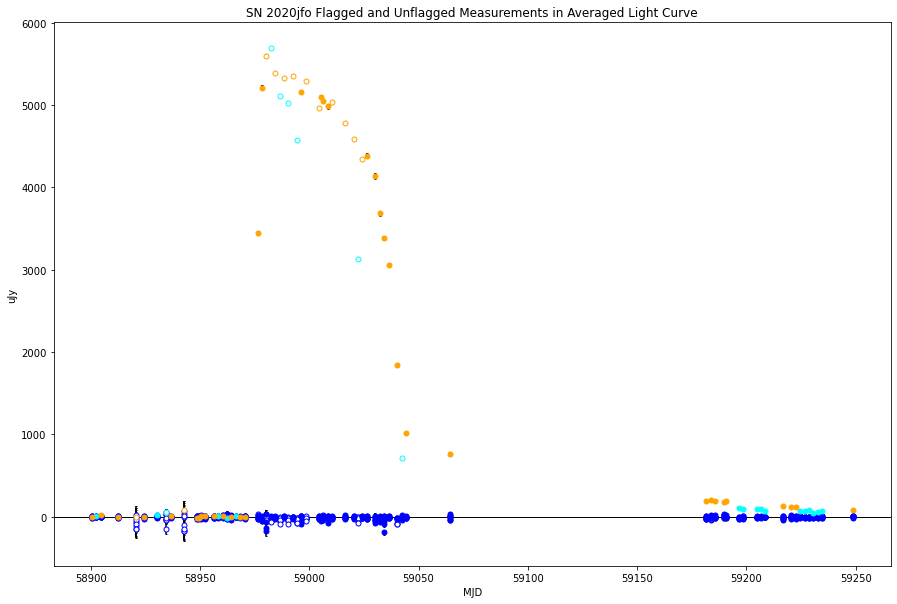

In [32]:
# PLOT-SPECIFIC SETTINGS:

# specify the plot's x and y limits (can set to None)
limits = {'xlim_lower':None,'xlim_upper':None,'ylim_lower':None,'ylim_upper':None}

plot_flagged = True # plot flagged measurements

flag_dict = {'flag_c0_bad':0x100000,'flag_c2_bad':0x400000,'flag_day_bad':0x800000}
# list flags from flag_dict above to mask bad measurements (flag_c2_bad and flag_day_bad only work if you used controls)
flags_list = ['flag_day_bad']

savefig = False # save figure after plotting




lc_dict = {}
if controls:
    if not(controls_num is None):
        end_num = controls_num
    else:
        print(controls_num)
        print('ERROR: no control light curve number entered in settings')
        sys.exit(1)
else:
    end_num = 0
if len(filts) < 1:
    print(filts)
    print('ERROR: must have at least one filter entered in settings')
if lw_mode and controls:
    print('ERROR: lw_mode cannot be True if control light curves used')

flags = 0x0
for flag in flags_list:
    flags = flags | flag_dict[flag]
plt.figure()
for index in range(0,end_num+1):
    lc_dict[index] = pdastroclass(hexcols=[maskcol])
    for filt in filts:
        if lw_mode:
            lc_dict[index].load_spacesep(name+'.'+filt+'.%0.2fdays.txt'%MJDbinsize,hexcols=['Mask'],delim_whitespace=True)
        else:
            lc_dict[index].load_spacesep(name+('_i%03d.'%index)+filt+'.%0.2fdays.lc.txt'%MJDbinsize,hexcols=['Mask'],delim_whitespace=True)
        if not(MJDstart is None) or not(MJDend is None):
            indices = lc_dict[index].ix_inrange(colnames=['MJD'],lowlim=MJDstart,uplim=MJDend)
        else:
            indices = lc_dict[index].getindices()
        indices_good = list(lc_dict[index].ix_unmasked('Mask',maskval=flags,indices=indices))
        indices_bad = list(lc_dict[index].ix_masked('Mask',maskval=flags,indices=indices))
        dygood = None
        dybad = None
        if show_errorbars: 
            dygood = lc_dict[index].t.loc[indices_good,'duJy']
            dybad = lc_dict[index].t.loc[indices_bad,'duJy']
        if index == 0:
            sp, plotSNg, dplotSNg = dataPlot(lc_dict[index].t.loc[indices_good,'MJD'],lc_dict[index].t.loc[indices_good,'uJy'],dy=dygood)
            matlib.setp(plotSNg,ms=5,color=filt_colors[filt],marker='o',zorder=10)
            if plot_flagged:
                sp, plotSNb, dplotSNb = dataPlot(lc_dict[index].t.loc[indices_bad,'MJD'],lc_dict[index].t.loc[indices_bad,'uJy'],dy=dybad)
                matlib.setp(plotSNb,ms=5,color=filt_colors[filt],marker='o',zorder=10,mfc='white')
        else:
            sp, plotg, dplotg = dataPlot(lc_dict[index].t.loc[indices_good,'MJD'],lc_dict[index].t.loc[indices_good,'uJy'],dy=dygood)
            matlib.setp(plotg,ms=5,color='b',marker='o')
            if plot_flagged:
                sp, plotb, dplotb = dataPlot(lc_dict[index].t.loc[indices_bad,'MJD'],lc_dict[index].t.loc[indices_bad,'uJy'],dy=dybad)
                matlib.setp(plotb,ms=5,color='b',marker='o',mfc='white')
if plot_flagged:
    plt.title('SN '+name+' Flagged and Unflagged Measurements in Averaged Light Curve')
else:
    plt.title('SN '+name+' Clean Averaged Light Curve')
plt.xlabel('MJD')
plt.ylabel('uJy')
plt.xlim(limits['xlim_lower'],limits['xlim_upper'])
plt.ylim(limits['ylim_lower'],limits['ylim_upper'])
#plt.legend((plotSNg,plotSNb,plotg,plotb),('SN '+name+' unflagged','SN '+name+' flagged','%d Control Light Curves unflagged'%end_num,'%d Control Light Curves flagged'%end_num))
plt.axhline(linewidth=1,color='k')
if savefig:
    if len(filts)==1:
        plt.savefig(name+'.'+filts[0]+'.avg.clean.png')
    plt.savefig(name+'.avg.clean.png',dpi=200)

### Chi-square or uncertainty values during the SN compared to before/after the SN

Text(0.5, 1.0, 'Sample SN 2020lse o-band frequency of chi/N')

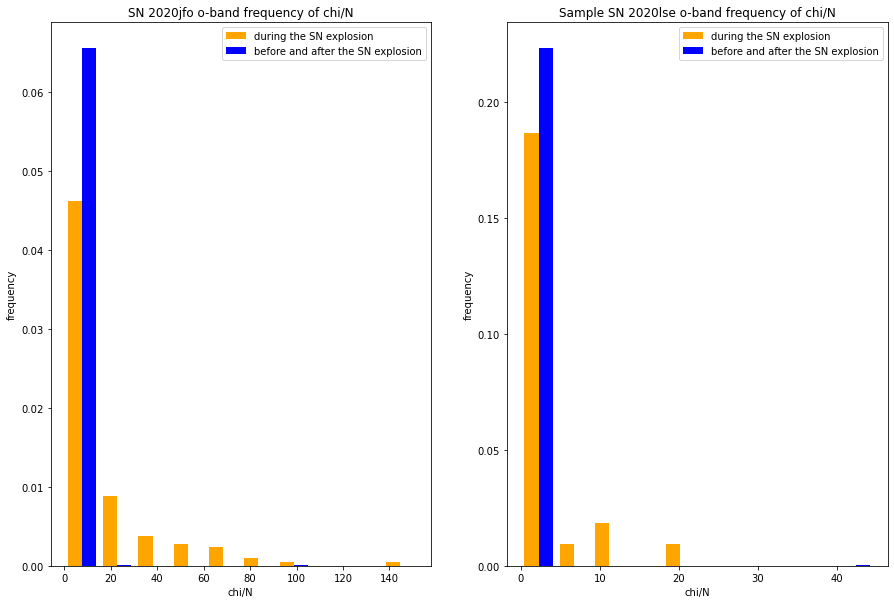

In [33]:
# PLOT-SPECIFIC SETTINGS:

# enter the MJD range of the SN:
SN_mjdstart = None
SN_mjdend = None
# parameter of flux to be examined:
parameter = 'chi/N' # can also change to 'duJy'to examine uncertainties
# filter:
filt = 'o'




if SN_mjdstart is None and SN_mjdend is None:
    raise RuntimeError('SN MJD start and end not given, please enter them!')
if filt == 'o':
    color = 'orange'
else:
    color = 'cyan'
colors = [color,'blue']
lc = pdastroclass(hexcols=[maskcol])
lc.load_spacesep(name+'_i000.'+filt+'.lc.txt',hexcols=['Mask'],delim_whitespace=True)
ix_SN = lc.ix_inrange(colnames=['MJD'],lowlim=SN_mjdstart,uplim=SN_mjdend)
ix_out = lc.ix_outrange(colnames=['MJD'],lowlim=SN_mjdstart,uplim=SN_mjdend,exclude_lowlim=True,exclude_uplim=True)

lc2 = pdastroclass(hexcols=[maskcol])
lc2.load_spacesep('2020lse_i000.'+filt+'.lc.txt',hexcols=['Mask'],delim_whitespace=True)
ix_SN2 = lc2.ix_inrange(colnames=['MJD'],lowlim=59000,uplim=59125)
ix_out2 = lc2.ix_outrange(colnames=['MJD'],lowlim=SN_mjdstart,uplim=SN_mjdend,exclude_lowlim=True,exclude_uplim=True)

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2)

ax0.hist([lc.t.loc[ix_SN,parameter],lc.t.loc[ix_out,parameter]],density=True,histtype='bar',color=colors,label=['during the SN explosion','before and after the SN explosion'],bins=10)
ax0.legend()
ax0.set_xlabel(parameter)
ax0.set_ylabel('frequency')
ax0.set_title('SN '+name+' '+filt+'-band frequency of '+parameter)

ax1.hist([lc2.t.loc[ix_SN2,parameter],lc2.t.loc[ix_out2,parameter]],density=True,histtype='bar',color=colors,label=['during the SN explosion','before and after the SN explosion'],bins=10)
ax1.legend()
ax1.set_xlabel(parameter)
ax1.set_ylabel('frequency')
ax1.set_title('Sample SN 2020lse'+' '+filt+'-band frequency of '+parameter)

### Chi-square and flux

Text(0, 0.5, 'chi/N')

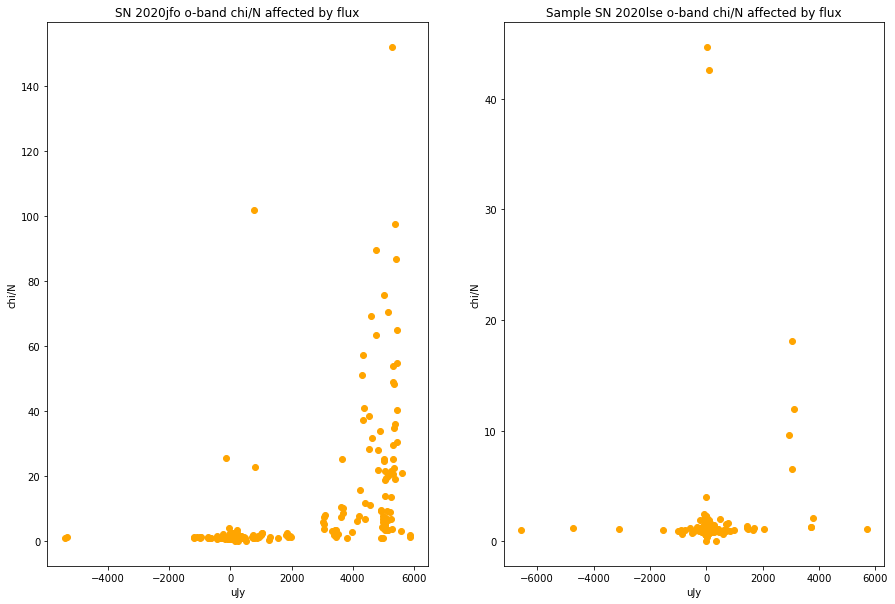

In [34]:
# PLOT-SPECIFIC SETTINGS:

# parameter of flux to be examined:
parameter = 'chi/N' # can also change to 'duJy'to examine uncertainties
# filter:
filt = 'o'




fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2)

ax0.scatter(lc.t['uJy'],lc.t[parameter],color=color)
ax0.set_title('SN '+name+' '+filt+'-band '+parameter+' affected by flux')
ax0.set_xlabel('uJy')
ax0.set_ylabel(parameter)

ax1.scatter(lc2.t['uJy'],lc2.t[parameter],color=color)
ax1.set_title('Sample SN 2020lse '+filt+'-band '+parameter+' affected by flux')
ax1.set_xlabel('uJy')
ax1.set_ylabel(parameter)

### Magnitude plots for either filter and either individual or averaged light curves

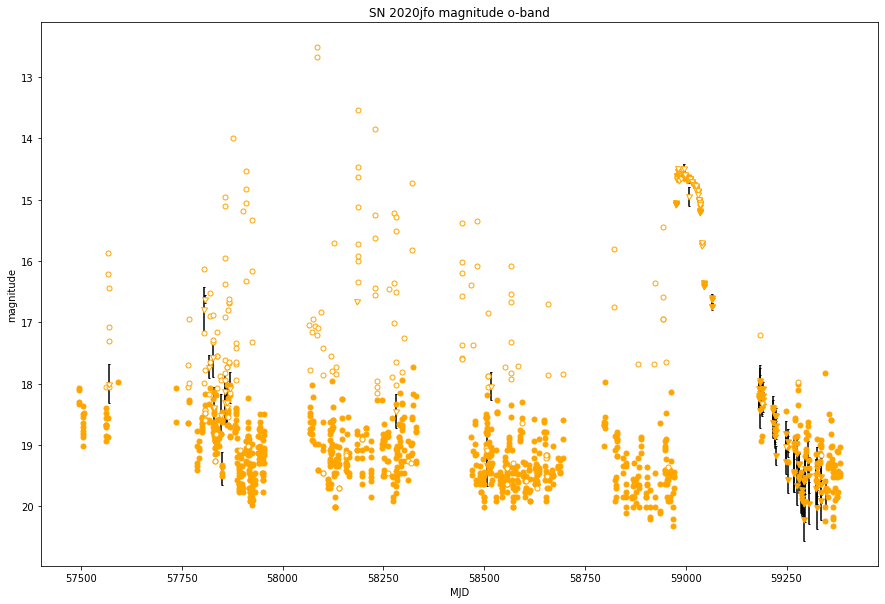

In [35]:
# PLOT-SPECIFIC SETTINGS:

# specify the plot's x and y limits (can set to None)
limits = {'xlim_lower':None,'xlim_upper':None,'ylim_lower':None,'ylim_upper':None}

filt = 'o' # options: ['c','o']
lc_type = 'individual' # options: ['individual','averaged']
mjdbinsize = 1 # averaged light curve MJD bin size in days

# define the flags
flags_dict = {'flag_c0_X2norm':0x1,
             'flag_c0_uncertainty':0x2,
             'flag_c0_bad':0x100000, # set if either flag_c0_X2norm or flag_c0_uncertainty
             'flag_c2_bad':0x400000, # control lc flag: set if control lcs indicate that something is wrong with epoch
             'flag_day_bad':0x800000} # flag for average lc if something is wrong
# choose the flags to be used
flags_list={}
flags_list['individual'] = ['flag_c0_bad'] # add in flag names from flag_dict to cut out measurements for single detection light curve
flags_list['averaged'] = ['flag_day_bad'] # add in flag names from flag_dict to cut out measurements for average light curve
plot_flagged = True # plot flagged measurements

savefig = False # save figure after plotting




# load in the lcs
lc = pdastroclass(hexcols=maskcol)
if lc_type == 'individual':
    lc.load_spacesep(name+'_i000.'+filt+'.lc.txt',hexcols=[maskcol])
elif lc_type == 'averaged':
    lc.load_spacesep(name+'_i000.'+filt+'.%0.2f'%mjdbinsize+'days.lc.txt',hexcols=[maskcol])
else:
    raise RuntimeError('Incorrect light curve type given. Must be individual or averaged.')

# get the correct indices
flags = 0x0
for flag in flags_list[lc_type]:
    flags = flags | flags_dict[flag]
ix_good = lc.ix_unmasked(maskcol,maskval=flags)
ix_bad = lc.ix_masked(maskcol,maskval=flags)
ix_ul = lc.ix_remove_null(colnames=['dm'])
ix_notul = AnotB(lc.getindices(),ix_ul)
ix_ul_good = AandB(ix_ul,ix_good)
ix_ul_bad = AandB(ix_ul,ix_bad)
ix_notul_good = AandB(ix_notul,ix_good)
ix_notul_bad = AandB(ix_notul,ix_bad)

# initialize the plot
plt.figure()
sp, plot_notul_good, dplot_notul_good = dataPlot(lc.t.loc[ix_notul_good,'MJD'],lc.t.loc[ix_notul_good,'m'],dy=lc.t.loc[ix_notul_good,'dm'])
matlib.setp(plot_notul_good,ms=5,color=filt_colors[filt],marker='o')
sp, plot_ul_good, dplot_ul_good = dataPlot(lc.t.loc[ix_ul_good,'MJD'],lc.t.loc[ix_ul_good,'m'],dy=lc.t.loc[ix_ul_good,'dm'])
matlib.setp(plot_ul_good,ms=7,color=filt_colors[filt],marker=(3, 0, 55))
if plot_flagged:
    sp, plot_notul_bad, dplot_notul_bad = dataPlot(lc.t.loc[ix_notul_bad,'MJD'],lc.t.loc[ix_notul_bad,'m'],dy=lc.t.loc[ix_notul_bad,'dm'])
    matlib.setp(plot_notul_bad,ms=5,color=filt_colors[filt],marker='o',mfc='white')
    sp, plot_ul_bad, dplot_ul_bad = dataPlot(lc.t.loc[ix_ul_bad,'MJD'],lc.t.loc[ix_ul_bad,'m'],dy=lc.t.loc[ix_ul_bad,'dm'])
    matlib.setp(plot_ul_bad,ms=7,color=filt_colors[filt],marker=(3, 0, 55),mfc='white')
plt.xlim(limits['xlim_lower'],limits['xlim_upper'])
plt.ylim(limits['ylim_lower'],limits['ylim_upper'])
plt.xlabel('MJD')
plt.ylabel('magnitude')
plt.gca().invert_yaxis()
plt.title('SN '+name+' magnitude '+filt+'-band')

# save the figure
if savefig:
    plt.savefig(name+'.'+filt+'.'+lc_type+'.mag.png',dpi=200)